# Train

In [2]:
import numpy as np
import pandas as pd 
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import csv
import tensorflow as tf
from PIL import Image
import os
import keras
import sys

# Import architectures
from keras.applications import xception

from keras.preprocessing import image
from tensorflow.keras.preprocessing import image as im
import time
import datetime

from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as K
from sklearn.preprocessing import OneHotEncoder

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, Model
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Input, AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout

import shutil

In [3]:
# Train phase

tf.keras.backend.set_learning_phase(1)

In [4]:
# Choose GPU

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
# 1) Path to train and test datasets
train_dir = "/home/linnik/Datasets/Signs/38_Classes/train/"   
test_dir = "/home/linnik/Datasets/Signs/38_Classes/test/"


# 2) Target width and height of input images, number of classes, number of train and test images, batch size, epochs
img_height, img_width = 72, 72
n_classes = len(os.listdir(train_dir))
nb_train_samples = sum([len(os.listdir(train_dir + folder)) for folder in os.listdir(train_dir)])
nb_test_samples = sum([len(os.listdir(test_dir + folder)) for folder in os.listdir(test_dir)])
batch_size = 128
epochs = 100


# 3) Name of file where will be saved trained model
model_name = "/home/linnik/Nets/Sign_Xception_72X72x3_38Classes.hdf5"


# 4) Compile parametrs
loss_ = 'categorical_crossentropy'
optimizer_ = 'adam'
metrics_ = ['acc']

In [6]:
train_datagen = ImageDataGenerator(
    rescale = 1.0 / 255,
    zoom_range = 0.2,
    rotation_range = 5,
    width_shift_range = img_width // 3,
    height_shift_range = img_height // 3,
    horizontal_flip = False,
    vertical_flip = False)

test_datagen = ImageDataGenerator(rescale = 1.0 / 255)

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical')

Found 122294 images belonging to 38 classes.
Found 16984 images belonging to 38 classes.


In [8]:
train_generator.class_indices

{'00': 0,
 '01': 1,
 '02': 2,
 '03': 3,
 '04': 4,
 '05': 5,
 '06': 6,
 '07': 7,
 '08': 8,
 '09': 9,
 '10': 10,
 '11': 11,
 '12': 12,
 '13': 13,
 '14': 14,
 '15': 15,
 '16': 16,
 '17': 17,
 '18': 18,
 '19': 19,
 '20': 20,
 '21': 21,
 '22': 22,
 '23': 23,
 '24': 24,
 '25': 25,
 '26': 26,
 '27': 27,
 '28': 28,
 '29': 29,
 '30': 30,
 '31': 31,
 '32': 32,
 '33': 33,
 '34': 34,
 '35': 35,
 '36': 36,
 '37': 37}

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(72, 72, 3)


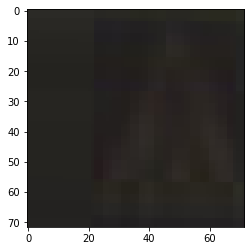

In [9]:
# Check size

for x, y in train_generator:
    plt.imshow(x[0])
    print(y[0])
    print(x[0].shape)
    break

In [10]:
# Create and compile Xception model

def build_model_Xception():
    base_model = xception.Xception(include_top = True, 
                                      weights = None,
                                      input_tensor = None,
                                      input_shape = (img_height, img_width, 3),
                                      pooling = None,
                                      classes = n_classes)
  
    for layer in base_model.layers:
        layer.trainable = True
      
    model = Model(inputs = base_model.input, outputs = base_model.output)
    return model


model = build_model_Xception()
model.compile(loss = loss_, optimizer = optimizer_, metrics = metrics_)

In [11]:
# Callbacks

early_stop = EarlyStopping(monitor = 'val_loss', patience = 8, verbose = 1, min_delta = 1e-4)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 4, verbose = 1, min_delta = 1e-4)
check = ModelCheckpoint(filepath = model_name, monitor = "val_acc", save_best_only = True)

callbacks_list = [early_stop, reduce_lr, check]

In [12]:
%%time

# Train model

model_history = model.fit_generator(
    train_generator,
    epochs = epochs,
    validation_data = test_generator,
    validation_steps = nb_test_samples // batch_size,
    callbacks = callbacks_list,
    steps_per_epoch = nb_train_samples // batch_size)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
726/955 [=====================>........] - ETA: 53s - loss: 0.8975 - acc: 0.7135

/home/linnik/.conda/envs/linnik/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


955/955 [==============================] - 232s 243ms/step - loss: 0.7339 - acc: 0.7660 - val_loss: 0.2225 - val_acc: 0.9399
Epoch 2/100
955/955 [==============================] - 176s 184ms/step - loss: 0.1479 - acc: 0.9541 - val_loss: 0.1869 - val_acc: 0.9476
Epoch 3/100
955/955 [==============================] - 176s 184ms/step - loss: 0.1066 - acc: 0.9673 - val_loss: 0.0837 - val_acc: 0.9759
Epoch 4/100
955/955 [==============================] - 176s 185ms/step - loss: 0.0906 - acc: 0.9723 - val_loss: 0.0770 - val_acc: 0.9770
Epoch 5/100
955/955 [==============================] - 177s 185ms/step - loss: 0.0779 - acc: 0.9764 - val_loss: 0.0685 - val_acc: 0.9810
Epoch 6/100
955/955 [==============================] - 177s 185ms/step - loss: 0.0737 - acc: 0.9780 - val_loss: 0.0984 - val_acc: 0.9753
Epoch 7/100
955/955 [==============================] - 177s 186ms/step - loss: 0.0619 - acc: 0.9811 - val_loss: 0.0745 - val_acc: 0.9795
Epoch 8/100
955/955 [==============================] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
os._exit(0)

# Test

In [13]:
# Test phase

tf.keras.backend.set_learning_phase(0)

In [14]:
# Load trained model

loaded_model = load_model(model_name)

In [15]:
# Speed test using generator

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (img_height, img_width),
    batch_size = 1,
    class_mode = 'categorical')

nb_samples = len(test_generator.filenames)

start_time = time.time()
predict = loaded_model.predict_generator(test_generator, steps = nb_samples)
print("Average time to pridict one photo using generator is", (time.time() - start_time)/nb_samples)

Found 16984 images belonging to 38 classes.
Average time to pridict one photo using generator is 0.0062612296835296965


In [16]:
def Precision_Recall_metrics(test_dir, model):
    n_classes = len(os.listdir(test_dir))
    
    right = 0
    wrong = 0
    times = []

    TP = [0 for i in range(n_classes)]
    FN = [0 for i in range(n_classes)]
    FP = [0 for i in range(n_classes)]
    precision = [0 for i in range(n_classes)]
    recall = [0 for i in range(n_classes)]

    for folder in os.listdir(test_dir):
        for img in os.listdir(test_dir + "/" + folder):
            imag = im.load_img(test_dir + "/" + folder + "/" + img, target_size = (img_height, img_width))

            photo_ar = im.img_to_array(imag)
            photo_ar = np.expand_dims(photo_ar, axis = 0)
            photo_ar /= 255

            start_time = time.time()
            ans = np.argmax(model.predict(photo_ar))
            times.append(time.time() - start_time)

            if ans == int(folder):
                right += 1
            else:
                wrong += 1


            if ans == int(folder):
                TP[ans] += 1
            if ans != int(folder):
                FN[ans] += 1
                FP[int(folder)] += 1


    for i in range(n_classes):
        try:
            precision[i] = TP[i]/(TP[i] + FP[i])
        except:
            precision[i] = 0

        try:
            recall[i] = TP[i]/(TP[i] + FN[i])
        except:
            recall[i] = 0
    precision = np.array(precision)
    recall = np.array(recall)
    
    accuracy = right/(right + wrong)
    avr_time = np.array(times).mean()
    
    return accuracy, avr_time, precision, recall

In [17]:
%%time

accuracy, avr_time, precision, recall = Precision_Recall_metrics(test_dir, loaded_model)
            

print("Accuracy on test set is", accuracy)
print("Average time to predict one photo without generator is", avr_time, "seconds")

print()

print("Precision:", precision)
print("Recall:", recall)

print()

print("Precision max, min, mean:", precision.max(), precision.min(), precision.mean())
print("Recall max, min, mean:", recall.max(), recall.min(), recall.mean())

Accuracy on test set is 0.996349505416863
Average time to predict one photo without generator is 0.006422488688299581 seconds

Precision: [0.9978903  0.99298246 0.99707174 1.         0.99671053 0.99404762
 0.99561404 1.         0.99056604 0.9989882  0.99577822 0.993
 1.         0.99590164 1.         0.98198198 0.99734748 0.99516908
 1.         0.99426934 0.99758454 0.99452055 0.99672131 1.
 1.         0.99280576 1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.96376812
 1.         0.99264706]
Recall: [1.         0.99647887 0.99416058 0.99173554 0.99019608 0.98816568
 0.99126638 0.99378882 0.99369085 0.9973064  0.995218   0.99899396
 1.         1.         0.9921875  1.         0.99470899 1.
 0.99776286 0.99426934 1.         0.98910082 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.99570815 1.         1.
 0.98550725 0.96428571]

Precision max, min, mean: 1.0 0.9637681159420289 0.996

<Figure size 1440x720 with 0 Axes>

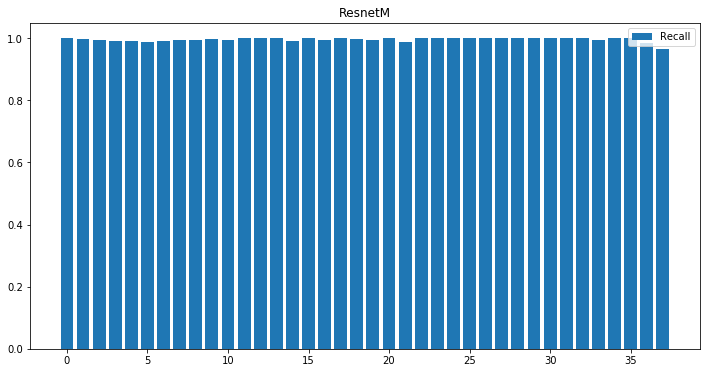

In [18]:
plt.figure(figsize = (20,10))
fig, ax = plt.subplots()

ax.bar(range(n_classes), recall, label = "Recall")
plt.legend(loc = 'best')
plt.title("ResnetM")

fig.set_figwidth(12)
fig.set_figheight(6)

<Figure size 1440x720 with 0 Axes>

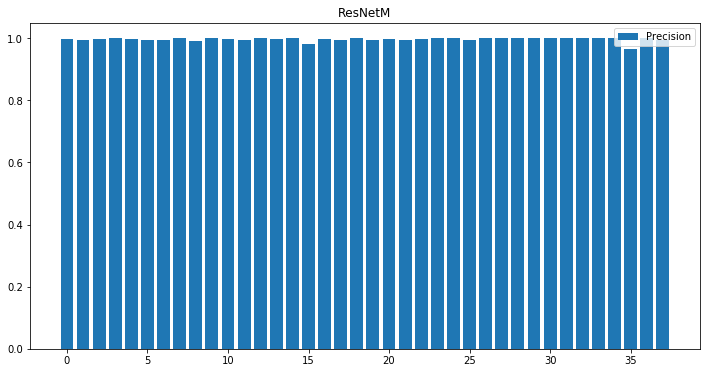

In [19]:
plt.figure(figsize = (20,10))
fig, ax = plt.subplots()

ax.bar(range(n_classes), precision, label = "Precision")
plt.legend(loc = 'best')
plt.title("ResNetM")


fig.set_figwidth(12)
fig.set_figheight(6)

In [28]:
import tensorflow as tf
from tensorflow.python.framework import graph_io
from tensorflow.keras.models import load_model

from keras.models import *
from keras.layers import *
from keras.optimizers import *

In [31]:
def freeze_graph(graph, session, output, save_pb_dir = '.', save_pb_name = 'frozen_model.pb', save_pb_as_text=False):
    with graph.as_default():
        graphdef_inf = tf.graph_util.remove_training_nodes(graph.as_graph_def())
        graphdef_frozen = tf.graph_util.convert_variables_to_constants(session, graphdef_inf, output)
        graph_io.write_graph(graphdef_frozen, save_pb_dir, save_pb_name, as_text=save_pb_as_text)
        return graphdef_frozen

session = tf.keras.backend.get_session()
init = tf.global_variables_initializer()
session.run(init)


input_names = [t.op.name for t in model.inputs]
output_names = [t.op.name for t in model.outputs]

frozen_graph = freeze_graph(session.graph, session, [out.op.name for out in model.outputs], 
                            save_pb_dir = '.', save_pb_name = 'frozen_model_ct2_Sign_ResNetM_72X72x3_33.pb')

Instructions for updating:
Use `tf.compat.v1.graph_util.remove_training_nodes`
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 146 variables.
INFO:tensorflow:Converted 146 variables to const ops.


In [32]:
# Prints input and output nodes names, take notes of them

print(input_names, output_names)

['input_1'] ['fc5/Softmax']


# Tune 4.3

In [26]:
for photo in os.listdir(test_dir + "34"):
    imag = im.load_img(test_dir + "34/" + photo, target_size = (img_height, img_width))

    photo_ar = im.img_to_array(imag)
    photo_ar = np.expand_dims(photo_ar, axis = 0)
    photo_ar /= 255
    
    pred = np.argmax(loaded_model.predict(photo_ar))    
    if pred != 34:
        shutil.move(test_dir + "34/" + photo, train_dir + "34/" + photo)

# Tune NKBVS

In [14]:
photos_dir = "/home/linnik/Datasets/Signs/nkbvs_ts_crops_RGB/"
temp_dir = "/home/linnik/Datasets/Signs/temp/"

for img in os.listdir(photos_dir):
    imag = im.load_img(photos_dir + img, target_size = (img_height, img_width))

    photo_ar = im.img_to_array(imag)
    photo_ar = np.expand_dims(photo_ar, axis = 0)
    photo_ar /= 255

    pred = np.argmax(loaded_model.predict(photo_ar))
    
    os.makedirs(temp_dir + str(pred), exist_ok = True)
    shutil.copy(photos_dir + img, temp_dir + str(pred))